In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
batch_size      = 64
test_batch_size = 1000
epochs          = 15
lr              = 0.01
momentum        = 0.9
log_interval    = 100
snip_prune_rate = 0.5  # 50% pruning
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:12<00:00, 812kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 92.7kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 838kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)


In [5]:
def snip_prune(model, data_loader, loss_fn, keep_ratio):
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()

    scores = {}
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            scores[name] = torch.abs(param * param.grad)

    # Concatenate all scores into a single tensor
    all_scores = torch.cat([torch.flatten(score) for score in scores.values()])
    num_params_to_keep = int(len(all_scores) * keep_ratio)
    threshold, _ = torch.kthvalue(all_scores, len(all_scores) - num_params_to_keep)

    # Create binary masks
    for name, param in model.named_parameters():
        if name in scores:
            mask = (scores[name] >= threshold).float()
            param.data *= mask  # Apply the mask directly
            print(f"Pruned {name}: Kept {mask.sum().item()} / {mask.numel()}")


In [7]:
snip_prune(model, train_loader, nn.NLLLoss(), keep_ratio=1 - snip_prune_rate)

# ─── Optimizer ────────────────────────────────────────────────────────────────
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# ─── Tracking ─────────────────────────────────────────────────────────────────
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

Pruned conv1.weight: Kept 286.0 / 288
Pruned conv2.weight: Kept 16872.0 / 18432
Pruned fc1.weight: Kept 581506.0 / 1179648
Pruned fc2.weight: Kept 1161.0 / 1280


In [8]:
def train(epoch):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')

    avg_loss = running_loss / len(train_loader.dataset)
    acc = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

# ─── Validation ───────────────────────────────────────────────────────────────
def validate():
    model.eval()
    correct, val_loss = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = val_loss / len(val_loader.dataset)
    acc = 100. * correct / len(val_loader.dataset)
    val_losses.append(avg_loss)
    val_accuracies.append(acc)
    print(f"\nValidation — Avg Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%\n")

Epoch 1 [6400/60000] Loss: 0.5502
Epoch 1 [12800/60000] Loss: 0.2000
Epoch 1 [19200/60000] Loss: 0.1823
Epoch 1 [25600/60000] Loss: 0.1554
Epoch 1 [32000/60000] Loss: 0.2857
Epoch 1 [38400/60000] Loss: 0.2021
Epoch 1 [44800/60000] Loss: 0.0799
Epoch 1 [51200/60000] Loss: 0.3052
Epoch 1 [57600/60000] Loss: 0.1548

Validation — Avg Loss: 0.0563, Accuracy: 98.17%

Epoch 2 [6400/60000] Loss: 0.1451
Epoch 2 [12800/60000] Loss: 0.0643
Epoch 2 [19200/60000] Loss: 0.2737
Epoch 2 [25600/60000] Loss: 0.0804
Epoch 2 [32000/60000] Loss: 0.0595
Epoch 2 [38400/60000] Loss: 0.0621
Epoch 2 [44800/60000] Loss: 0.1527
Epoch 2 [51200/60000] Loss: 0.0955
Epoch 2 [57600/60000] Loss: 0.0955

Validation — Avg Loss: 0.0427, Accuracy: 98.64%

Epoch 3 [6400/60000] Loss: 0.0202
Epoch 3 [12800/60000] Loss: 0.0826
Epoch 3 [19200/60000] Loss: 0.0244
Epoch 3 [25600/60000] Loss: 0.1431
Epoch 3 [32000/60000] Loss: 0.2124
Epoch 3 [38400/60000] Loss: 0.0475
Epoch 3 [44800/60000] Loss: 0.0362
Epoch 3 [51200/60000] Loss: 

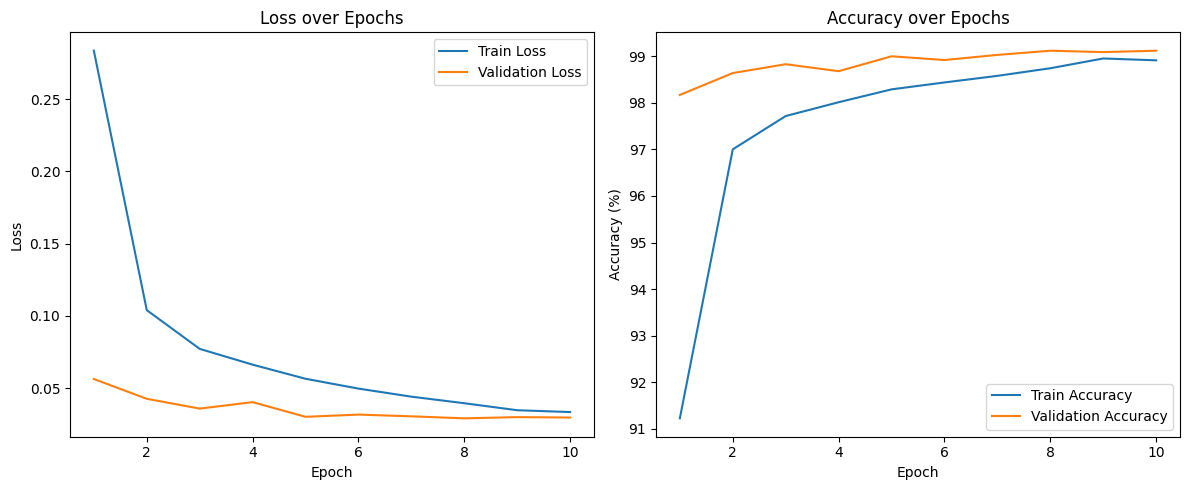

In [9]:
if __name__ == '__main__':
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        train(epoch)
        validate()

    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f'\n⏱️ Total Time: {mins:.0f}m {secs:.2f}s')

    print("\n✅ Final Metrics:")
    print(f"Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Training Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")

    # ─── Plot ─────────────────────────────────────────────────────────────────
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()